# (4) Training and Validation

One of the key factors which limits the use of neural networks in many industrial applications has been the difficulty of demonstrating that a trained network will continue to generate reliable outputs once it is in routine use. [Source](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/05/Bishop-Novelty-Detection_IEE-Proceedings-94b.pdf).

That is the motivation for the [validation and test splits](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) mentioned in the (2) Data Structure tutorial. In that tutorial we seperated training and testing data, and later during the training we will specify the validation fraction. In order to train our model, first we need to extract the training and testing data and build the model.

In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import h5py
import pandas as pd

Using TensorFlow backend.


In [2]:
Inputs = Input(shape=(10,))
x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='fc1_relu')(Inputs)
predictions = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(x)
model = Model(inputs=Inputs, outputs=predictions)

In [3]:
f = h5py.File('C:\\Users\\45148\\UW-EPE-ML-Tutorials\\processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

features = ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c2_b1_mmdt', 'j_d2_b1_mmdt', 'j_d2_a1_b1_mmdt',
            'j_m2_b1_mmdt', 'j_n2_b1_mmdt', 'j_mass_mmdt', 'j_multiplicity']
labels = ['j_t']

features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_val = features_labels_df[features].values #Convert to numpy array
labels_val = features_labels_df[labels].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

## Training

The [loss function](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/) essentially represents the error calculated from predicted and true values; in practice, this function be hard to determine.

Binary cross-entropy is the standard loss function for binary classification problems. It is used when the target values are eitiher {0,1} and only one target is possible at a time. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

An optimizer is the function which updates the weight parameters to minimize the loss function. The loss function represents the surface, and the optimizer is the method to reach the lowest point of that surface. Here is an article about different kinds of [optimizers](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3). The [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) affects the magnitude of change between each training example, or how 'far' to descend the loss gradient. It is generally a very small number, and there are callback methods to adjust the learning rate dynamically.

In this model, we will be using Adam because it is a generally effective optimizer.

In [ ]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Next, we will use the [model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function to train the network. Read about the parameters in the documentation.

Batch_size represents the size of data bins used to train the network, since with large volumes of data it cannot fit all onto your RAM at one time. An epoch is one iteration through the entire shuffled data set; with additional epochs, the data is reshuffled and used to train the network again. Callbacks are used in between epochs, and can be highly customized.

The validation split represents the fraction of the remaining training data to use as a validation set during the training. That is important so that the loss or error of the network will be computed on data which it hasn't trained on, leading to more robust solutions. Then towards the end, the network is again evaluated on the _test_ data set that we split off in the beginning, which the network has never seen before.

In [ ]:
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

The model is now trained! It took 100s on my intel-i7 CPU. It is possible for tensorflow to be optimized using a GPU, if you have an NVIDIA graphics card that is CUDA compatible. Feel free to enable this yourself if applicable, but for these tutorials and many smaller models a CPU will work at a reasonable enough pace.

The output of the fit function is a history object, which contains the values of loss for the training data as well as the validation data, and whatever metrics specified for each epoch.

To save the model, Tensorflow has very user friendly functions,

In [ ]:
model.save('two-layer') #Saves to local directory; model file 'two-layer' with no extension

And it is just as easy to load the model. This is useful when the training takes a long time, so you only need to train it once. Both the save and load arguments can take different paths to the file, but here it is in the local directory.

In [ ]:
loaded_model = keras.models.load_model('two-layer') #Loads from local directory

In [ ]:
loaded_model.summary()

## Validation

To validate the robustness of the networks predictions and ensure that the network isn't overfit on our sample, we want to compare the loss on the training set versus the loss on the validation set. The plot comparing the two over each epoch is called the 'learning curve'.

In [4]:
import matplotlib.pyplot as plt

In [5]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

In [ ]:
learningCurve(history)

Divergence of the validation and training sample losses implies overfitting on your training data set. The above is quite a beautiful learning curve. You can see that it converges around 0.3, and every training epoch after around 10 epochs gives marginal improvement.

So we've discovered that the model is not overfit, next we want to know how it performs. One very popular measure of _classifier_ performance is called the [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). It is a plot of the true positive rate (signal efficiency) versus the false positive rate (background efficiency). [Understanding the ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

We will use our *test* sample that we split in the very beginning, and use our network to predict the output and compare it with the true output.

In [ ]:
labels_pred = model.predict(features_val)

That was the _inference_ calculation. The network just predicted the labels based on the features provided. I am providing you with this method to plot the learning curve, as this is a machine learning tutorial not a plotting tutorial; that said, you should inspect the code and make sure you understand the use of roc_curve() and auc() and what exactly is being plotted.

In [6]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [ ]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='two-layer')

The above is the learning curve for the two-layer model. A perfect classifier would look like a line from coordinates (0,0) to (1,0) to (1,1); following the left and upper border of the plot. A classifier whose AUC is below 50% can be reversed in implementation to give greater than 50% AUC. The worst possible classifier would follow the black dotted line, with a minimum AUC of 50% and offer no greater descrimination than flipping a coin.

After the exercise, this concludes the ML tutorial. You've downloaded and understood the structure of a sample LHC data set (pre-processed; the processing of the data is another problem of its own), built a model, trained it, and validated it through inspecting the learning curve and ROC curve. Congratulations!

##### Exercise

Train and plot the learning and ROC curves of the four-layer model. Use the Adam and binary-crossentropy losses with the same parameters. The training might take longer, so it is okay to stop it once it has more or less converged ( >= 20 epochs). Use the provided methods to do the plotting.

In [7]:
Inputs_exercise = Input(shape=(16,))
a = Dense(64, activation='relu', kernel_initializer='lecun_uniform', name='fc1_relu')(Inputs_exercise)
b = Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='fc2_relu')(a)
c = Dense(32, activation='relu', kernel_initializer='lecun_uniform', name='fc3_relu')(b)
predictions_exercise = Dense(5, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(c)
model_exercise = Model(inputs=Inputs_exercise, outputs=predictions_exercise)

In [8]:
features_exercise = ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 
                     'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 
                     'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_mmdt', 'j_multiplicity']
labels_exercise = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']

features_labels_df_exercise = pd.DataFrame(treeArray,columns=features_exercise+labels_exercise)
features_labels_df_exercise = features_labels_df_exercise.drop_duplicates()

features_val_exercise = features_labels_df_exercise[features_exercise].values #Convert to numpy array
labels_val_exercise = features_labels_df_exercise[labels_exercise].values

In [9]:
X_train_exercise, X_test_exercise, y_train_exercise, y_test_exercise = train_test_split(features_val_exercise, 
                                                                                        labels_val_exercise, 
                                                                                        test_size=0.2, 
                                                                                        random_state=42)

In [10]:
adam_exercise = Adam(lr=0.0001)
model_exercise.compile(optimizer=adam_exercise, loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history_exercise = model_exercise.fit(X_train_exercise, y_train_exercise, batch_size = 1024, epochs = 100, 
                                      validation_split = 0.25, shuffle = True, callbacks = None, 
                                      use_multiprocessing=True, workers=4)

Epoch 1/100
579/579 [==============================] - 1s 2ms/step - loss: 0.6403 - accuracy: 0.3210 - val_loss: 0.4527 - val_accuracy: 0.3837
Epoch 2/100
579/579 [==============================] - 1s 2ms/step - loss: 0.4407 - accuracy: 0.3979 - val_loss: 0.4289 - val_accuracy: 0.4153
Epoch 3/100
579/579 [==============================] - 1s 2ms/step - loss: 0.4207 - accuracy: 0.4319 - val_loss: 0.4108 - val_accuracy: 0.4595
Epoch 4/100
579/579 [==============================] - 1s 1ms/step - loss: 0.4013 - accuracy: 0.5136 - val_loss: 0.3908 - val_accuracy: 0.5457
Epoch 5/100
579/579 [==============================] - 1s 1ms/step - loss: 0.3845 - accuracy: 0.5669 - val_loss: 0.3767 - val_accuracy: 0.5825
Epoch 6/100
579/579 [==============================] - 1s 1ms/step - loss: 0.3731 - accuracy: 0.5850 - val_loss: 0.3682 - val_accuracy: 0.5854
Epoch 7/100
579/579 [==============================] - 1s 1ms/step - loss: 0.3657 - accuracy: 0.5940 - val_loss: 0.3617 - val_accuracy: 0.5975

Epoch 58/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2832 - accuracy: 0.7024 - val_loss: 0.2832 - val_accuracy: 0.7030
Epoch 59/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2830 - accuracy: 0.7023 - val_loss: 0.2819 - val_accuracy: 0.7040
Epoch 60/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2824 - accuracy: 0.7030 - val_loss: 0.2819 - val_accuracy: 0.7051
Epoch 61/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2819 - accuracy: 0.7036 - val_loss: 0.2808 - val_accuracy: 0.7047
Epoch 62/100
579/579 [==============================] - 1s 2ms/step - loss: 0.2816 - accuracy: 0.7037 - val_loss: 0.2811 - val_accuracy: 0.7045
Epoch 63/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2812 - accuracy: 0.7040 - val_loss: 0.2812 - val_accuracy: 0.7046
Epoch 64/100
579/579 [==============================] - 1s 1ms/step - loss: 0.2807 - accuracy: 0.7044 - val_loss: 0.2805 - val_accuracy:

In [12]:
model_exercise.save('four-layer') #Saves to local directory; model file 'two-layer' with no extension

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: four-layer\assets


In [13]:
loaded_model_exercise = keras.models.load_model('four-layer') #Loads from local directory

In [14]:
loaded_model_exercise.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 64)                1088      
_________________________________________________________________
fc2_relu (Dense)             (None, 32)                2080      
_________________________________________________________________
fc3_relu (Dense)             (None, 32)                1056      
_________________________________________________________________
output_sigmoid (Dense)       (None, 5)                 165       
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________


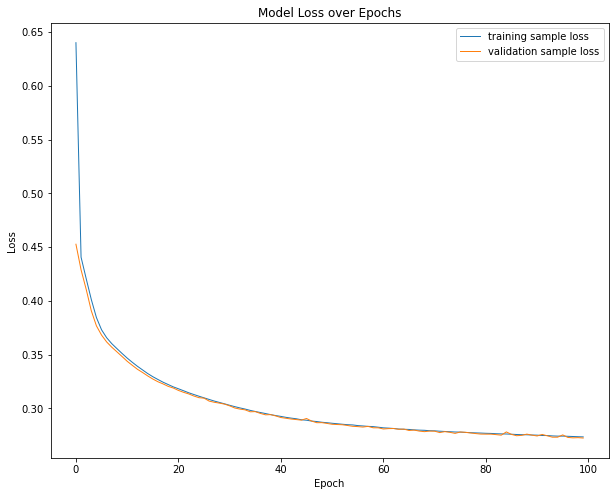

In [15]:
learningCurve(history_exercise)

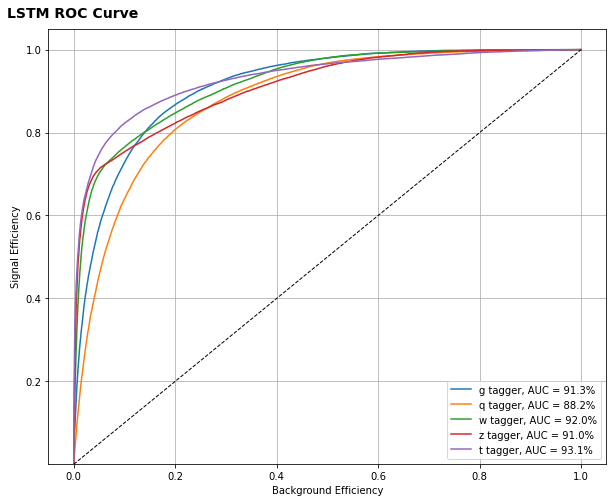

In [16]:
y_pred_exercise = makeRoc(X_test_exercise, y_test_exercise, labels_exercise, model_exercise, outputSuffix='four-layer')